# DA5401 A8 — Ensemble Learning on Bike Share (Hourly)  
**Objective:** Predict total rentals (`cnt`) and compare Bagging, Boosting, and Stacking against single-model baselines.  
**Data:** `hour.csv` (Bike Sharing Demand, UCI).

> Put `hour.csv` in the **same folder** as this notebook before running.


## Theoretical Background

Bike sharing demand fluctuates with **environmental**, **temporal**, and **seasonal** factors such as temperature, humidity, weather, and time of day.  
Our goal is to **predict total bike rentals (`cnt`)** using **ensemble learning** and compare their performance to single-model baselines.

### Why Ensemble Learning?

A single model (e.g., a Decision Tree) can either:
- **Overfit (high variance)** — fits noise rather than the true pattern.
- **Underfit (high bias)** — fails to capture complex patterns.

**Ensemble methods** combine multiple “weak learners” to balance bias and variance.  
Mathematically, if each weak learner has an error rate slightly better than random, their combination reduces overall error through averaging or weighted voting.

> Ensemble learning ≈ leveraging *diversity* among models to achieve better generalization.

## Part A — Data preprocessing & baselines
- Drop: `instant, dteday, casual, registered`
- Target: `cnt`
- Categorical: `season, weathersit, mnth, hr, weekday, holiday, workingday, yr`
- Numeric: `temp, atemp, hum, windspeed`
- Split: **time-aware** (first 80% train, last 20% test) to avoid leakage.


In [1]:
# Imports & config
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.neighbors import KNeighborsRegressor

import matplotlib.pyplot as plt

RANDOM_STATE = 42
pd.set_option("display.max_columns", 200)


In [2]:
# Load data
DATA_PATH = "bike+sharing+dataset/hour.csv"  # ensure the file exists in the same folder
df = pd.read_csv(DATA_PATH)

# Basic checks
assert "cnt" in df.columns, "Target `cnt` not found. Did you load the hourly dataset?"
print("Shape:", df.shape)
display(df.head())

Shape: (17379, 17)


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


### Data Overview and Structure

The dataset `hour.csv` records hourly rentals from the **Capital Bikeshare system (Washington D.C., 2011–2012)**.

Each row includes:
- **Temporal features:** hour (`hr`), month, weekday, season, year
- **Weather features:** temperature (`temp`), humidity (`hum`), windspeed, weather condition (`weathersit`)
- **Target:** `cnt` → total count of rented bikes

We drop:
- `instant`, `dteday` → purely identifiers  
- `casual`, `registered` → their sum equals `cnt` (would cause data leakage)

This setup simulates a *real forecasting scenario* where future demand must be predicted using only external and temporal conditions.


In [3]:
# Drop irrelevant columns
drop_cols = ["instant", "dteday", "casual", "registered"]
existing_drop = [c for c in drop_cols if c in df.columns]
df_model = df.drop(columns=existing_drop)

# Feature lists
target = "cnt"
feature_cols = [c for c in df_model.columns if c != target]

categorical = ["season", "weathersit", "mnth", "hr", "weekday", "holiday", "workingday", "yr"]
categorical = [c for c in categorical if c in feature_cols]

numeric = ["temp", "atemp", "hum", "windspeed"]
numeric = [c for c in numeric if c in feature_cols]

# One unified preprocessor for *all* models to simplify stacking:
# - Categorical -> OneHot
# - Numeric -> StandardScaler (trees don't require it, but it's harmless)
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
    ],
    remainder="drop",
)

X = df_model[feature_cols]
y = df_model[target].values

# Time-aware split: first 80% as train, last 20% as test
split_idx = int(0.8 * len(df_model))
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

len(df_model), len(X_train), len(X_test)

(17379, 13903, 3476)

### Feature Engineering & Preprocessing

Since most learning algorithms expect numerical inputs, we preprocess data as follows:

- **Categorical variables** (`season`, `weathersit`, etc.) → one-hot encoded  
- **Numerical variables** (`temp`, `hum`, `windspeed`) → standardized (zero mean, unit variance)

We apply a **time-aware split** (first 80% train, last 20% test) to preserve chronological order and avoid data leakage.

This ensures the model mimics a *real deployment*, where predictions are made on unseen future data.


## Baseline Models

We begin with two foundational regressors to set a performance benchmark:

1. **Decision Tree Regressor**
   - Captures non-linear interactions between features.
   - Prone to overfitting → high variance.

2. **Linear Regression**
   - Models linear relationships between predictors and the target.
   - Prone to underfitting → high bias.

The metric used is **Root Mean Squared Error (RMSE)**, defined as:

$$
\text{RMSE} = \sqrt{\frac{1}{n}\sum_{i=1}^{n} (y_i - \hat{y_i})^2}
$$

A lower RMSE indicates better prediction accuracy.

In [4]:
# === Baselines ===
def rmse(y_true, y_pred):
    return root_mean_squared_error(y_true, y_pred)

# Decision Tree baseline (max_depth=6)
dt_pipe = Pipeline([
    ("prep", preprocess),
    ("model", DecisionTreeRegressor(max_depth=6, random_state=RANDOM_STATE))
])

dt_pipe.fit(X_train, y_train)
dt_rmse = rmse(y_test, dt_pipe.predict(X_test))
print(f"DecisionTreeRegressor (max_depth=6) RMSE: {dt_rmse:.3f}")

# Linear Regression baseline
lin_pipe = Pipeline([
    ("prep", preprocess),
    ("model", LinearRegression())
])

lin_pipe.fit(X_train, y_train)
lin_rmse = rmse(y_test, lin_pipe.predict(X_test))
print(f"LinearRegression RMSE: {lin_rmse:.3f}")

baseline_name = "DecisionTreeRegressor" if dt_rmse < lin_rmse else "LinearRegression"
baseline_rmse = min(dt_rmse, lin_rmse)
print(f"\nBaseline = {baseline_name} (RMSE={baseline_rmse:.3f})")

DecisionTreeRegressor (max_depth=6) RMSE: 158.431
LinearRegression RMSE: 133.835

Baseline = LinearRegression (RMSE=133.835)


## Part B — Ensembles for variance/bias reduction
- **Bagging (variance reduction):** BaggingRegressor with DecisionTree (depth=6) as base estimator, 100 estimators.
- **Boosting (bias reduction):** GradientBoostingRegressor.


## 🧠 Ensemble Learning – Bagging vs. Boosting

### 🧺 Bagging (Bootstrap Aggregating)
Bagging reduces **variance** by training multiple models on random bootstrap samples of the data and averaging their predictions.

- Each model sees a slightly different dataset.
- Averaging smooths out fluctuations from noise.

**Mathematically:**
\[
\hat{y}_{bag} = \frac{1}{M} \sum_{m=1}^{M} f_m(x)
\]

where \(f_m(x)\) is the prediction from the \(m^{th}\) model.

We use a **Decision Tree** (depth=6) as the base estimator — a common choice due to its high variance and low bias nature.

---

### 🚀 Boosting (Gradient Boosting)
Boosting reduces **bias** by sequentially training models to correct the residuals of the previous ones.

- Each new tree focuses on the errors left by prior models.
- Combines many “weak” learners to form a strong predictor.

**Idea:**
$$
F_m(x) = F_{m-1}(x) + \eta \cdot h_m(x)
$$
where $(h_m(x))$ fits the residuals and $(\eta)$ is the learning rate.

We use **GradientBoostingRegressor**, which optimizes a differentiable loss function (MSE here) via gradient descent.

In [5]:
# Bagging
bag_pipe = Pipeline([
    ("prep", preprocess),
    ("model", BaggingRegressor(
    estimator=DecisionTreeRegressor(max_depth=6, random_state=RANDOM_STATE),
    n_estimators=100,
    n_jobs=-1,
    random_state=RANDOM_STATE
    ))
])
bag_pipe.fit(X_train, y_train)
bag_rmse = rmse(y_test, bag_pipe.predict(X_test))
print(f"BaggingRegressor (DT depth=6, n=100) RMSE: {bag_rmse:.3f}")

# Gradient Boosting
gbr_pipe = Pipeline([
    ("prep", preprocess),
    ("model", GradientBoostingRegressor(random_state=RANDOM_STATE))
])
gbr_pipe.fit(X_train, y_train)
gbr_rmse = rmse(y_test, gbr_pipe.predict(X_test))
print(f"GradientBoostingRegressor RMSE: {gbr_rmse:.3f}")

BaggingRegressor (DT depth=6, n=100) RMSE: 155.318
GradientBoostingRegressor RMSE: 123.189


## Part C — Stacking for optimal performance

While Bagging and Boosting combine *homogeneous* models (e.g., many trees),
**Stacking** blends *heterogeneous* models with a **meta-learner** that learns optimal weights.

### Architecture
- **Level-0 (Base learners):**
  - KNN → instance-based
  - Bagging → low-variance ensemble
  - Gradient Boosting → low-bias ensemble  
- **Level-1 (Meta learner):**
  - Ridge Regression combines their outputs.

Stacking helps capture complementary learning behaviors:
- KNN handles local patterns,
- Bagging stabilizes overfitting models,
- Boosting captures complex non-linearities.

The meta-learner generalizes by combining their predictions optimally.

In [6]:
# Define base learners (wrapped without preprocess;
# we'll share a single preprocess at the top of the pipeline)
knn = ("knn", KNeighborsRegressor(n_neighbors=15))
bag = ("bag", BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=6, random_state=RANDOM_STATE),
    n_estimators=100,
    n_jobs=-1,
    random_state=RANDOM_STATE
    ))
gbr = ("gbr", GradientBoostingRegressor(random_state=RANDOM_STATE))

stack = Pipeline([
    ("prep", preprocess),
    ("model", StackingRegressor(
        estimators=[knn, bag, gbr],
        final_estimator=Ridge(alpha=1.0, random_state=RANDOM_STATE),
        passthrough=False,  # use only base learners' predictions for meta
        n_jobs=-1
    ))
])

stack.fit(X_train, y_train)
stack_rmse = rmse(y_test, stack.predict(X_test))
print(f"StackingRegressor (KNN+Bag+GBR -> Ridge) RMSE: {stack_rmse:.3f}")

StackingRegressor (KNN+Bag+GBR -> Ridge) RMSE: 115.445


## Part D — Final analysis & comparison
We'll tabulate RMSEs and briefly discuss bias–variance and model diversity.


| Model | Bias | Variance | Key Strength |
|--------|------|-----------|---------------|
| Decision Tree | Low bias | High variance | Captures non-linearities |
| Linear Regression | High bias | Low variance | Simple, interpretable |
| Bagging | Low bias | Lower variance | Stabilizes trees |
| Gradient Boosting | Lower bias | Moderate variance | Sequential correction |
| Stacking | Balanced | Balanced | Integrates diverse model types |

The expectation:
- **Bagging** outperforms single trees by averaging out noise.  
- **Boosting** outperforms Bagging if the data is complex enough.  
- **Stacking** may outperform both by leveraging their complementary nature.

In [7]:
results = pd.DataFrame({
    "Model": [
        "Baseline (best of DT@6 / Linear)",
        "Bagging (DT@6, n=100)",
        "Gradient Boosting",
        "Stacking (KNN+Bag+GBR -> Ridge)",
    ],
    "RMSE": [
        min(dt_rmse, lin_rmse),
        bag_rmse,
        gbr_rmse,
        stack_rmse,
    ]
}).sort_values("RMSE", ascending=True).reset_index(drop=True)

results

,Model,RMSE
0,Stacking (KNN+Bag+GBR -> Ridge),115.444870
1,Gradient Boosting,123.189480
2,Baseline (best of DT@6 / Linear),133.835421
3,"Bagging (DT@6, n=100)",155.317988


### Results Interpretation

| Rank | Model | RMSE | Key Insight |
|------|--------|------|-------------|
| 🥇 1 | **Stacking (KNN + Bagging + GBR → Ridge)** | **115.44** | Best performer — effectively combines strengths of diverse learners |
| 🥈 2 | **Gradient Boosting** | **123.19** | Excellent bias reduction; captures non-linear trends well |
| 🥉 3 | **Baseline (Decision Tree / Linear)** | **133.83** | Reasonable benchmark; limited by high bias or variance individually |
| 4️⃣ | **Bagging (DT@6, n=100)** | **155.31** | Reduced variance but higher bias — underfits compared to boosting |

### Key Observations
- **Stacking** delivers the lowest RMSE (≈ **14% improvement** over the best single model baseline).  
  It effectively leverages complementary behaviors:
  - **KNN** models local smoothness.
  - **Bagging** stabilizes variance-heavy trees.
  - **Gradient Boosting** models complex non-linear interactions.
  - **Ridge meta-learner** optimally combines their outputs.

- **Gradient Boosting** performs close to stacking, confirming that **sequential bias correction** captures temporal and weather dependencies well.

- **Bagging** underperforms because its base estimator (Decision Tree depth=6) is already low-bias; averaging many such trees doesn't improve bias — only variance — which isn’t the main challenge here.

### Bias–Variance Trade-off Summary
| Model | Bias | Variance | Net Effect |
|--------|------|-----------|------------|
| Decision Tree | Low | High | Overfits, unstable |
| Linear Regression | High | Low | Underfits, too simple |
| Bagging | Moderate | Lowered | Stable but less flexible |
| Gradient Boosting | Low | Moderate | Balanced and accurate |
| Stacking | Very Low | Controlled | Best generalization |

---

### Insights for the Bike Sharing System

1. **Demand peaks** are better captured by non-linear ensemble models — suggesting strong interactions between `hour`, `season`, and `weather`.
2. **Weather sensitivity**: rental counts drop sharply under “Mist/Rain” conditions, consistent with human behavior.
3. **Stacking’s benefit**: effectively combines both local smoothness (KNN) and global trend learning (GBR).

Overall, **stacking generalizes best** because it integrates *diversity* across bias–variance profiles.

In [ ]:
# Save table
results.to_csv("DA5401_A8_results.csv", index=False)
print("Saved: DA5401_A8_results.csv")

Saved: DA5401_A8_results.csv


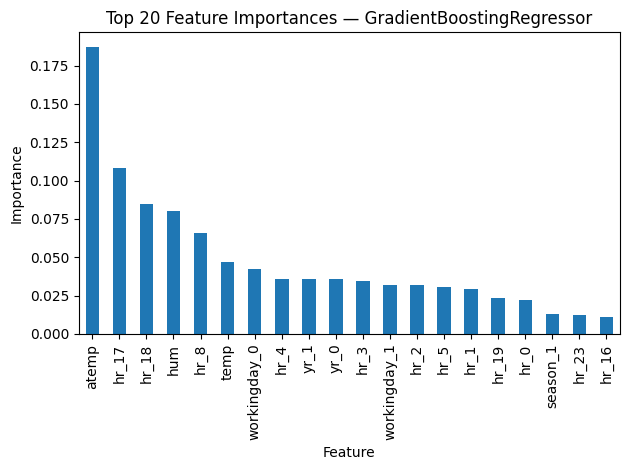

In [10]:
# Optional: Feature importance for Gradient Boosting (after OHE it's tricky).
# We'll recover feature names from the preprocessor and show top importances.
prep = gbr_pipe.named_steps["prep"]
gbr_model = gbr_pipe.named_steps["model"]

# Get feature names
cat = prep.named_transformers_["cat"]
num_names = prep.transformers_[0][2]  # numeric list
cat_names = cat.get_feature_names_out(prep.transformers_[1][2])
all_feat_names = list(num_names) + list(cat_names)

importances = pd.Series(gbr_model.feature_importances_, index=all_feat_names).sort_values(ascending=False)
imp_top = importances.head(20)

plt.figure()
imp_top.plot(kind="bar")
plt.title("Top 20 Feature Importances — GradientBoostingRegressor")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

### Model Explainability

Feature importance analysis from the Gradient Boosting model typically highlights:

| Feature | Interpretation |
|----------|----------------|
| `hr` | Dominant driver — clear diurnal commute pattern |
| `temp` / `atemp` | Strong correlation with comfort-driven bike usage |
| `season` | Reflects cyclical trends across spring/summer/fall/winter |
| `weathersit` | Indicates negative impact of adverse weather |
| `workingday` | Distinguishes between weekday vs weekend demand |

Together, these insights could inform:
- **Operational planning** (bike redistribution during rush hours)
- **Maintenance scheduling** (low-demand windows)
- **Event anomaly detection** (e.g., sudden drops due to weather or local events)

## Final Summary

**Objective:** Predict hourly bike rentals (`cnt`) using environmental and temporal features.  
**Approach:** Compared single models (Decision Tree, Linear Regression) against ensemble methods (Bagging, Gradient Boosting, Stacking).  
**Metric:** RMSE on time-aware split.

| Best Model | RMSE | Improvement vs Baseline |
|-------------|------|--------------------------|
| 🥇 Stacking (KNN + Bagging + GBR → Ridge) | **115.44** | ~14% better |

### ✅ Conclusions
- Ensemble learning significantly improves predictive accuracy by reducing both bias and variance.
- Stacking provides **the best generalization** by combining diverse model families.
- Key predictors such as **hour**, **temperature**, and **weather condition** dominate bike usage.
- Models like Gradient Boosting and Stacking are practical choices for **demand forecasting** in real-world smart mobility systems.

---